In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model/

#!unzip "/content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model/data/P8_Cityscapes_gtFine_trainvaltest.zip" -d "./data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model


In [ ]:
#!unzip "/content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model/data/P8_Cityscapes_leftImg8bit_trainvaltest.zip" -d "./data"

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import os

# Répertoire racine de Cityscapes
CITYSCAPES_ROOT = "./data"  # ⚠️ À adapter

# Images et masques, par split
LEFTIMG_DIR = os.path.join(CITYSCAPES_ROOT, "leftImg8bit")
MASK_DIR    = os.path.join(CITYSCAPES_ROOT, "gtFine")

# Chemins complets
TRAIN_IMG_DIR = os.path.join(LEFTIMG_DIR, "train")
VAL_IMG_DIR   = os.path.join(LEFTIMG_DIR, "val")
TEST_IMG_DIR  = os.path.join(LEFTIMG_DIR, "test")

TRAIN_MASK_DIR = os.path.join(MASK_DIR, "train")
VAL_MASK_DIR   = os.path.join(MASK_DIR, "val")
TEST_MASK_DIR  = os.path.join(MASK_DIR, "test")

# Autres paramètres globaux
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 8
IMG_WIDTH, IMG_HEIGHT = 512, 256
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 16

torch.cuda.is_available()

torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.get_device_name()




(True, 0, 'Tesla T4')

In [ ]:
!find ./data -type f -name "*frankfurt_000000_000294_leftImg8bit.png"


./data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png


In [ ]:
# Dossier racine
base_path = "./data"

# Exemple avec une image de validation
city = "frankfurt"
image_name = "frankfurt_000000_000294_leftImg8bit.png"

# Chemins
image_path = os.path.join(base_path, "leftImg8bit", "val", city, image_name)
mask_path = os.path.join(base_path, "gtFine", "val", city, image_name.replace("leftImg8bit", "gtFine_labelIds"))

# Chargement
image = Image.open(image_path)
mask = Image.open(mask_path)

# Conversion en array
image_np = np.array(image)
mask_np = np.array(mask)


In [ ]:
# Mapping de l’ID des classes vers les 8 catégories principales
CITYSCAPES_8_CLASSES = {
        # flat
        7: 0, 8: 0, 9: 7, 10: 7,  # road, sidewalk, parking, rail track

        # human
        24: 1, 25: 1,  # person, rider

        # vehicle
        26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2,  # car, truck, bus, train, motorcycle, etc.

        # construction
        11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 4,  # building, wall, fence, etc.

        # object
        18: 4, 19: 4, 20: 4,  # pole, traffic light/sign

        # nature
        21: 5, 22: 5,  # vegetation, terrain

        # sky
        23: 6,  # sky

        # void (tout le reste → 7)
}

def remap_mask(mask):
    """Transforme les classes Cityscapes en 8 classes cibles (valeurs 0 à 7)"""
    mask_array = np.array(mask)
    new_mask = np.zeros_like(mask_array)

    for k, v in CITYSCAPES_8_CLASSES.items():
        new_mask[mask_array == k] = v

    return new_mask.astype(np.int64)  # ✅ conversion explicite



In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2




train_transform = A.Compose([
    A.Resize(height=IMG_SIZE[1], width=IMG_SIZE[0]),  # (960, 1920)
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMG_SIZE[1], width=IMG_SIZE[0]),  # (960, 1920)
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform =  A.Compose([
    A.Resize(height=IMG_SIZE[1], width=IMG_SIZE[0]),  # (960, 1920)
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = Image.open(self.mask_paths[idx])
        mask = remap_mask(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()


In [ ]:
import glob
def get_cityscapes_pairs(img_root, mask_root, split="train"):
    image_paths = []
    mask_paths = []

    for city in os.listdir(img_root):
        img_files = glob.glob(os.path.join(img_root, city, "*_leftImg8bit.png"))
        for img_path in img_files:
            # Extrait le nom de fichier sans extension
            filename = os.path.basename(img_path).replace("_leftImg8bit.png", "")
            mask_path = os.path.join(mask_root, city, f"{filename}_gtFine_labelIds.png")

            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)
            else:
                print(f"❌ Masque non trouvé pour : {mask_path}")

    print(f"✅ {split} : {len(image_paths)} paires valides trouvées")
    return image_paths, mask_paths


In [ ]:
train_img, train_mask = get_cityscapes_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR, "train")
val_img, val_mask = get_cityscapes_pairs(VAL_IMG_DIR, VAL_MASK_DIR, "val")


✅ train : 2975 paires valides trouvées
✅ val : 500 paires valides trouvées


In [ ]:
train_dataset = SegmentationDataset(train_img, train_mask, transform=train_transform)
val_dataset = SegmentationDataset(val_img, val_mask, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
def denormalize(image_tensor, mean, std):
    """
    Dénormalise un tenseur image normalisé.
    """
    device = image_tensor.device  # 👈 On récupère le device de l'image
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)
    return (image_tensor * std + mean).clamp(0, 1)


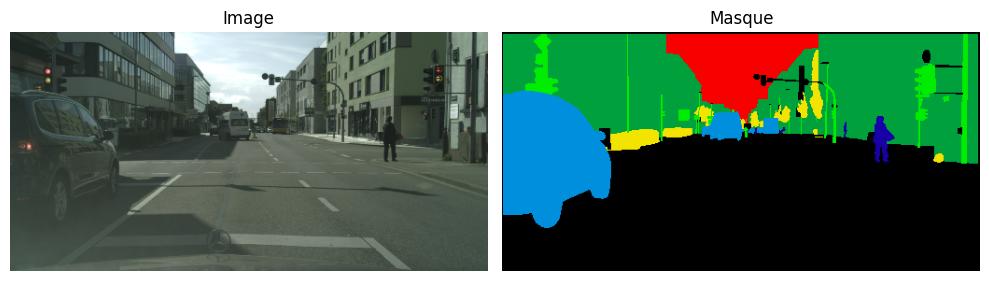

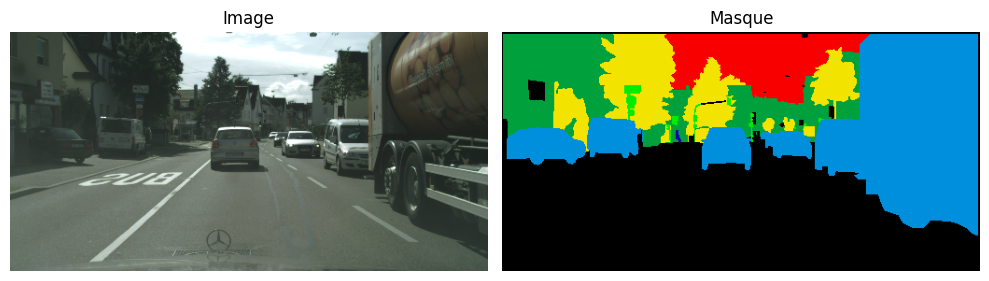

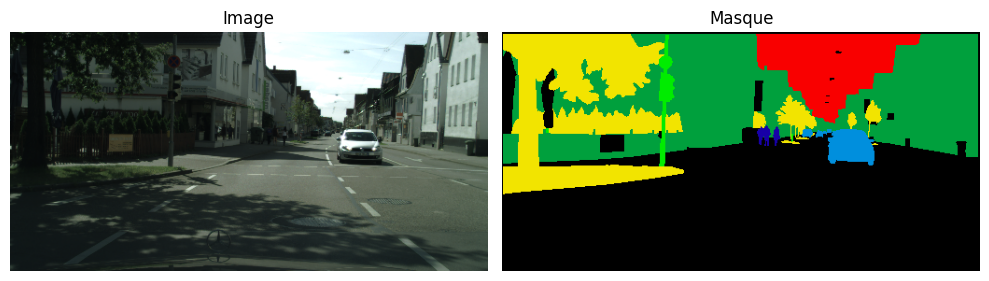

In [ ]:
import matplotlib.pyplot as plt

def show_sample(dataset, n=3):
    """
    Affiche n paires (image, masque) à partir d'un dataset PyTorch.
    """

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    for i in range(n):
        image, mask = dataset[i]
        image = denormalize(image, mean, std)

        # Conversion pour affichage
        image_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()

        # Affichage
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image_np)
        axs[0].set_title("Image")
        axs[0].axis("off")

        axs[1].imshow(mask_np, cmap="nipy_spectral", vmin=0, vmax=NUM_CLASSES-1)
        axs[1].set_title("Masque")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()

show_sample(train_dataset)


In [ ]:
def get_test_images(img_root, n=3):
    test_images = []

    for city in os.listdir(img_root):
        img_files = glob.glob(os.path.join(img_root, city, "*_leftImg8bit.png"))
        img_files.sort()  # pour la reproductibilité

        for img_path in img_files:
            test_images.append(img_path)
            if len(test_images) >= n:
                break
        if len(test_images) >= n:
            break

    print(f"✅ test : {len(test_images)} images chargées pour prédiction")
    return test_images


In [ ]:
test_img_paths = get_test_images(TEST_IMG_DIR, n=3)


✅ test : 3 images chargées pour prédiction


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2



In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, img_path



In [ ]:
test_dataset = TestDataset(test_img_paths, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:

from collections import Counter
import numpy as np

label_counts = Counter()

for i in range(100):  # Prends un sous-ensemble du dataset
    _, mask = train_dataset[i]
    labels, counts = np.unique(mask, return_counts=True)
    for l, c in zip(labels, counts):
        label_counts[int(l)] += int(c)

print("Distribution des classes (sur 100 images) :")
for k in sorted(label_counts):
    print(f"Classe {k} → {label_counts[k]}")


Distribution des classes (sur 100 images) :
Classe 0 → 6123802
Classe 1 → 124864
Classe 2 → 1364071
Classe 3 → 3086577
Classe 4 → 234426
Classe 5 → 1658673
Classe 6 → 500811
Classe 7 → 13976


#### 2.1. Modèle Baseline (U-Net simple ou FCN)



## 2.1. Modèle Baseline (U-Net simple ou FCN)

In [ ]:
!pip install -q mlflow


In [ ]:
import mlflow
import mlflow.pytorch
import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch


# ✅ Fonction de perte (pour classification pixel à pixel)
loss_fn = nn.CrossEntropyLoss()
BEST_METRIC = -float("inf")
PATIENCE = 5
PATIENCE_COUNTER = 0
EPOCHS = 25
LEARNING_RATE = 1e-4


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetBaseline(nn.Module):
    def __init__(self, in_channels=3, num_classes=8):
        super(UNetBaseline, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)


In [ ]:
def compute_metrics(preds, targets, num_classes):
    preds = torch.argmax(preds, dim=1)

    ious = []
    correct_pixels = 0
    total_pixels = 0

    for cls in range(num_classes):
        pred_mask = preds == cls
        target_mask = targets == cls

        intersection = (pred_mask & target_mask).sum().item()
        union = (pred_mask | target_mask).sum().item()

        if union == 0:
            iou = float('nan')  # ignore class not present
        else:
            iou = intersection / union
            ious.append(iou)

        correct_pixels += (pred_mask == target_mask).sum().item()
        total_pixels += target_mask.numel()

    pixel_acc = correct_pixels / total_pixels
    mean_iou = np.nanmean(ious)

    return mean_iou, pixel_acc


In [ ]:
from torch.amp import GradScaler
from torch.amp import autocast

scaler = GradScaler()


def train_one_epoch(model, loader, optimizer, loss_fn, device):
    torch.cuda.empty_cache()
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            if isinstance(model(images), dict):
                outputs = model(images)["out"]
            else:
                outputs = model(images)

            if outputs.shape[-2:] != masks.shape[-2:]:
                outputs = nn.functional.interpolate(
                    outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False
                )

            loss = loss_fn(outputs, masks)

        scaler.scale(loss).backward()        # 🧪 backward avec échelle AMP
        scaler.step(optimizer)               # 🧠 step AMP
        scaler.update()                      # 🔄 update AMP

        running_loss += loss.item()

    return running_loss / len(loader)


In [ ]:
def evaluate_model(model, loader, loss_fn, device, num_classes):
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    n_batches = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            if isinstance(model(images), dict):
                outputs = model(images)["out"]
            else:
                outputs = model(images)
            if outputs.shape[-2:] != masks.shape[-2:]:
                outputs = nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            iou, acc = compute_metrics(outputs, masks, num_classes)
            total_iou += iou
            total_acc += acc
            n_batches += 1

    return (
        val_loss / n_batches,
        total_iou / n_batches,
        total_acc / n_batches
    )


In [ ]:
model = UNetBaseline(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")



with mlflow.start_run(run_name="UNet_baseline"):
    mlflow.log_params({
        "model": "UNetBaseline",
        "optimizer": "Adam",
        "lr": 1e-4,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model.state_dict(), "best_model.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model.pt")


Époch 1 | Train Loss: 1.1224 | Val Loss: 0.7980 | mIoU: 0.4265 | Pixel Acc: 0.9601
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 2 | Train Loss: 0.6779 | Val Loss: 0.6009 | mIoU: 0.4643 | Pixel Acc: 0.9665
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 3 | Train Loss: 0.5245 | Val Loss: 0.4835 | mIoU: 0.4933 | Pixel Acc: 0.9699
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 4 | Train Loss: 0.4394 | Val Loss: 0.4647 | mIoU: 0.5140 | Pixel Acc: 0.9679
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 5 | Train Loss: 0.3880 | Val Loss: 0.5081 | mIoU: 0.4834 | Pixel Acc: 0.9620
⚠️ Pas d'amélioration : 1/5
Époch 6 | Train Loss: 0.3569 | Val Loss: 0.3779 | mIoU: 0.5487 | Pixel Acc: 0.9721
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 7 | Train Loss: 0.3333 | Val Loss: 0.3613 | mIoU: 0.5651 | Pixel Acc: 0.9726
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 8 | Train Loss: 0.3147 | Val Loss: 0.3482 | mIoU: 0.5683 | Pi

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model(input_tensor)  # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


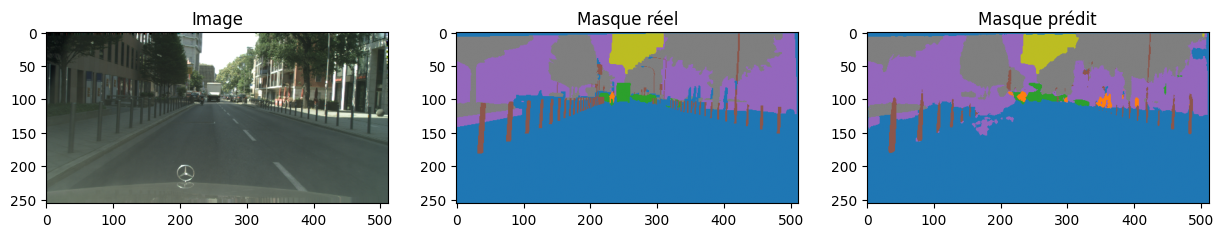

In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


#### 2.2. Modèle From Scratch (U-Net complet)


In [ ]:
import torch
import torch.nn as nn

class UNetFull(nn.Module):
    def __init__(self, in_channels=3, num_classes=8):
        super(UNetFull, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)


In [ ]:
import torch.optim as optim
import mlflow
import mlflow.pytorch

model2 = UNetFull(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE)
# ✅ Optimiseur
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)



In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")

BEST_METRIC = -float("inf")
PATIENCE_COUNTER = 0
with mlflow.start_run(run_name="UNet_Full"):
    mlflow.log_params({
        "model": "UNetFull",
        "optimizer": "Adam",
        "lr": LEARNING_RATE,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model2, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model2, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model2.state_dict(), "best_model2.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model2.pt")


Époch 1 | Train Loss: 0.8501 | Val Loss: 0.6293 | mIoU: 0.4539 | Pixel Acc: 0.9649
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 2 | Train Loss: 0.5266 | Val Loss: 0.4969 | mIoU: 0.4579 | Pixel Acc: 0.9677
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 3 | Train Loss: 0.4363 | Val Loss: 0.4271 | mIoU: 0.4758 | Pixel Acc: 0.9706
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 4 | Train Loss: 0.3820 | Val Loss: 0.4369 | mIoU: 0.4964 | Pixel Acc: 0.9683
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 5 | Train Loss: 0.3429 | Val Loss: 0.3569 | mIoU: 0.5585 | Pixel Acc: 0.9736
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 6 | Train Loss: 0.3145 | Val Loss: 0.3950 | mIoU: 0.5303 | Pixel Acc: 0.9695
⚠️ Pas d'amélioration : 1/5
Époch 7 | Train Loss: 0.2947 | Val Loss: 0.3072 | mIoU: 0.5882 | Pixel Acc: 0.9763
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 8 | Train Loss: 0.2808 | Val Loss: 0.3114 | mIoU: 0.5859 | Pi

In [ ]:
model2.load_state_dict(torch.load("best_model2.pt"))
model2.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model2(input_tensor)  # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


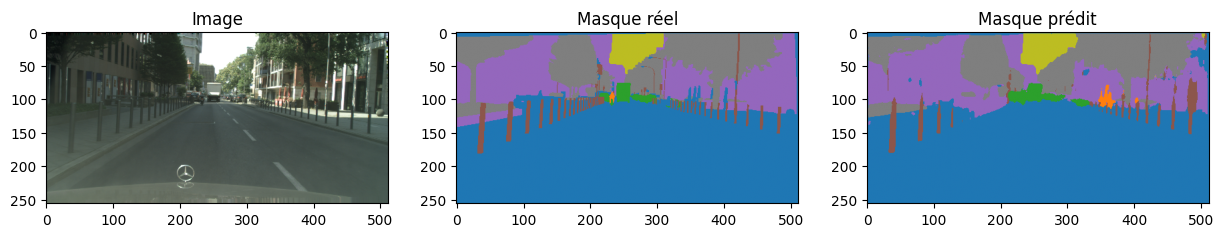

In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


In [ ]:
def afficher_prediction(image_tensor, pred_mask, path, mean, std, num_classes):
    # Dénormaliser
    image_denorm = denormalize(image_tensor.squeeze(0), mean=mean, std=std)
    image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
    pred_np = pred_mask  # déjà en numpy

    # Affichage
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(image_np)
    axs[0].set_title("Image")
    axs[1].imshow(pred_np, cmap="tab10", vmin=0, vmax=num_classes - 1)
    axs[1].set_title("Masque prédit")

    fig.suptitle(f"🖼️ {os.path.basename(path)}")
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


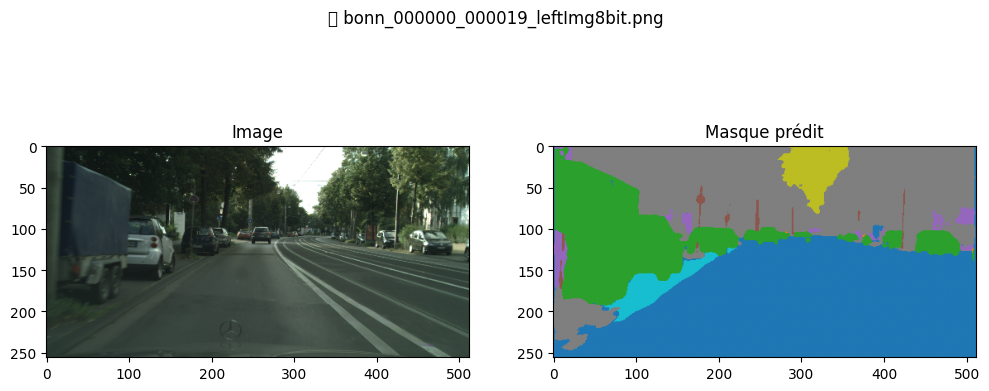

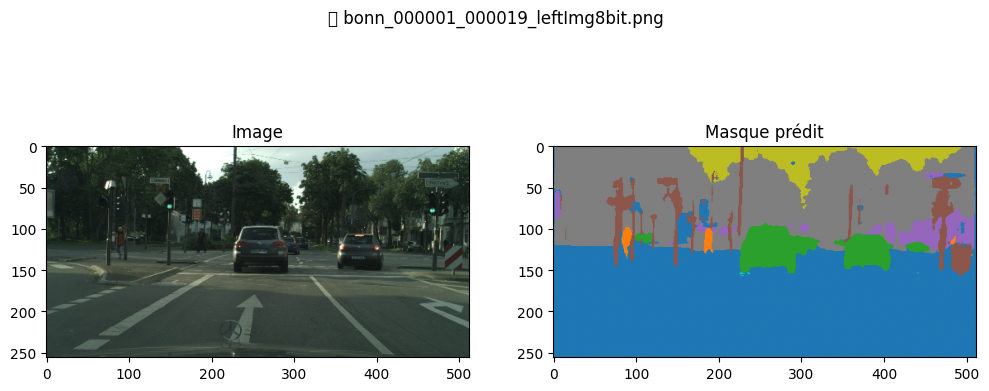

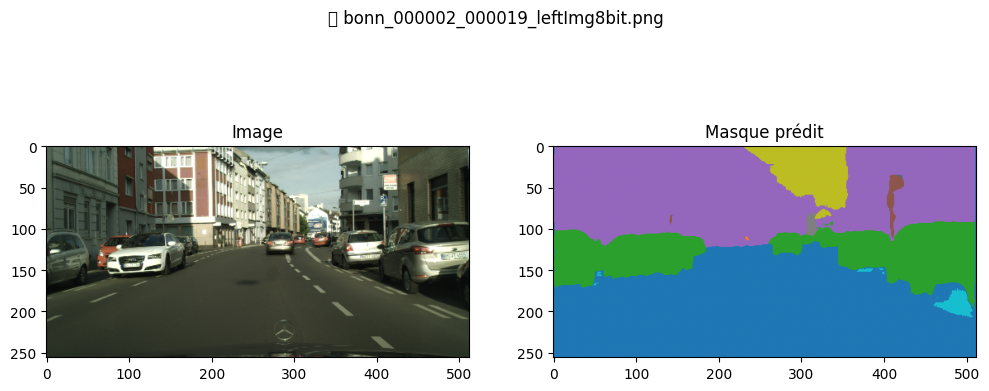

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

model2.eval()
with torch.no_grad():
    for img_tensor, path in test_loader:
        img_tensor = img_tensor.to(DEVICE)
        output = model2(img_tensor)
        pred_mask = output.argmax(1).squeeze(0).cpu().numpy()

        afficher_prediction(img_tensor, pred_mask, path[0], mean, std, NUM_CLASSES)



#### 2.3. Modèle Transfert Learning ( U-Net + ResNet34)

In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import segmentation_models_pytorch as smp

def get_unet_resnet34_model(num_classes=8):
    model = smp.Unet(
        encoder_name="resnet34",          # backbone
        encoder_weights="imagenet",       # transfert learning
        in_channels=3,                    # RGB
        classes=num_classes               # segmentation des 8 classes
    )
    return model


In [ ]:
model3 = get_unet_resnet34_model(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")

BEST_METRIC = -float("inf")
PATIENCE_COUNTER = 0
with mlflow.start_run(run_name="UNet_ResNet34"):

    mlflow.log_params({
        "model": "UNet_ResNet34",
        "optimizer": "Adam",
        "lr": LEARNING_RATE,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model3, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model3, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model3.state_dict(), "best_model_unet_resnet34.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model_unet_resnet34.pt")


Époch 1 | Train Loss: 1.0424 | Val Loss: 0.6065 | mIoU: 0.4868 | Pixel Acc: 0.9709
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 2 | Train Loss: 0.4712 | Val Loss: 0.4030 | mIoU: 0.5124 | Pixel Acc: 0.9751
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 3 | Train Loss: 0.3449 | Val Loss: 0.3314 | mIoU: 0.5236 | Pixel Acc: 0.9763
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 4 | Train Loss: 0.2914 | Val Loss: 0.2954 | mIoU: 0.5409 | Pixel Acc: 0.9775
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 5 | Train Loss: 0.2566 | Val Loss: 0.2752 | mIoU: 0.6117 | Pixel Acc: 0.9796
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 6 | Train Loss: 0.2289 | Val Loss: 0.2571 | mIoU: 0.6384 | Pixel Acc: 0.9806
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 7 | Train Loss: 0.2100 | Val Loss: 0.2480 | mIoU: 0.6474 | Pixel Acc: 0.9807
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 8 | Train Loss: 0.1961 | Val Loss: 

In [ ]:
model3.load_state_dict(torch.load("best_model_unet_resnet34.pt"))
model3.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model2(input_tensor)  # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


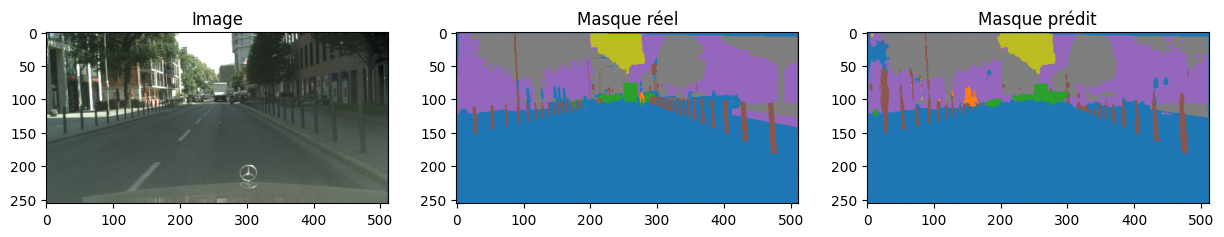

In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


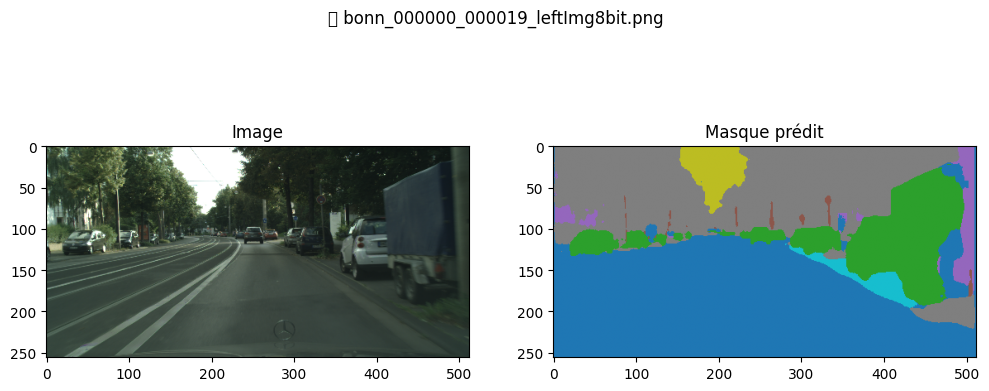

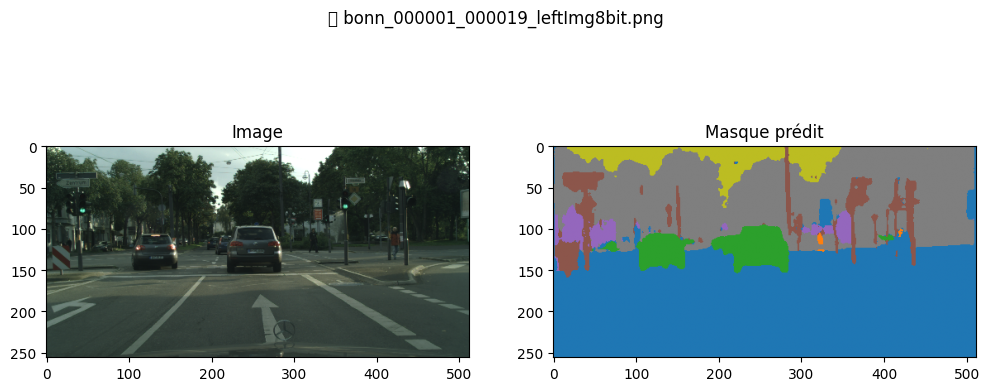

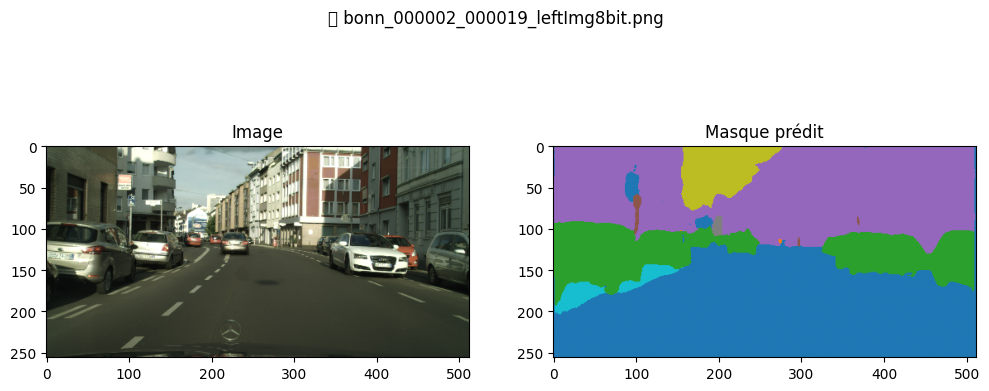

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

model3.eval()
with torch.no_grad():
    for img_tensor, path in test_loader:
        img_tensor = img_tensor.to(DEVICE)
        output = model3(img_tensor)
        pred_mask = output.argmax(1).squeeze(0).cpu().numpy()

        afficher_prediction(img_tensor, pred_mask, path[0], mean, std, NUM_CLASSES)



# Unet + Resnet50 custom

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.stage0 = nn.Sequential(base.conv1, base.bn1, base.relu)
        self.stage1 = nn.Sequential(base.maxpool, base.layer1)
        self.stage2 = base.layer2
        self.stage3 = base.layer3
        self.stage4 = base.layer4

    def forward(self, x):
        x0 = self.stage0(x)
        x1 = self.stage1(x0)
        x2 = self.stage2(x1)
        x3 = self.stage3(x2)
        x4 = self.stage4(x3)
        return x0, x1, x2, x3, x4

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch + skip_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            skip = F.interpolate(skip, size=x.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)



In [ ]:
class UNetResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = ResNetEncoder()

        self.center = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2)
        )

        self.dec4 = DecoderBlock(1024, 1024, 512)
        self.dec3 = DecoderBlock(512, 512, 256)
        self.dec2 = DecoderBlock(256, 256, 128)
        self.dec1 = DecoderBlock(128, 64, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x0, x1, x2, x3, x4 = self.encoder(x)

        x = self.center(x4)
        x = self.dec4(x, x3)
        x = self.dec3(x, x2)
        x = self.dec2(x, x1)
        x = self.dec1(x, x0)

        x = self.final(x)

        return x


In [ ]:
model4 = UNetResNet(num_classes=8).to(DEVICE)
optimizer = torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE)



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")

BEST_METRIC = -float("inf")
with mlflow.start_run(run_name="UNet_ResNet50_Custom"):

    mlflow.log_params({
        "model": "UNet_Custom_ResNet50",
        "optimizer": "Adam",
        "lr": LEARNING_RATE,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model4, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model4, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model4.state_dict(), "best_model_unet_custom_resnet50.pt")
            print("Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model_unet_custom_resnet50.pt")


Époch 1 | Train Loss: 0.6926 | Val Loss: 0.3781 | mIoU: 0.4833 | Pixel Acc: 0.9711
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 2 | Train Loss: 0.3172 | Val Loss: 0.2957 | mIoU: 0.5471 | Pixel Acc: 0.9762
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 3 | Train Loss: 0.2609 | Val Loss: 0.2581 | mIoU: 0.5943 | Pixel Acc: 0.9787
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 4 | Train Loss: 0.2345 | Val Loss: 0.2494 | mIoU: 0.6213 | Pixel Acc: 0.9795
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 5 | Train Loss: 0.2116 | Val Loss: 0.2446 | mIoU: 0.6275 | Pixel Acc: 0.9798
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 6 | Train Loss: 0.1956 | Val Loss: 0.2301 | mIoU: 0.6588 | Pixel Acc: 0.9811
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 7 | Train Loss: 0.1824 | Val Loss: 0.2265 | mIoU: 0.6650 | Pixel Acc: 0.9813
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 8 | Train Loss: 0.1686 | Val Loss: 

In [ ]:
model4.load_state_dict(torch.load("best_model_unet_custom_resnet50.pt"))
model4.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model2(input_tensor)  # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


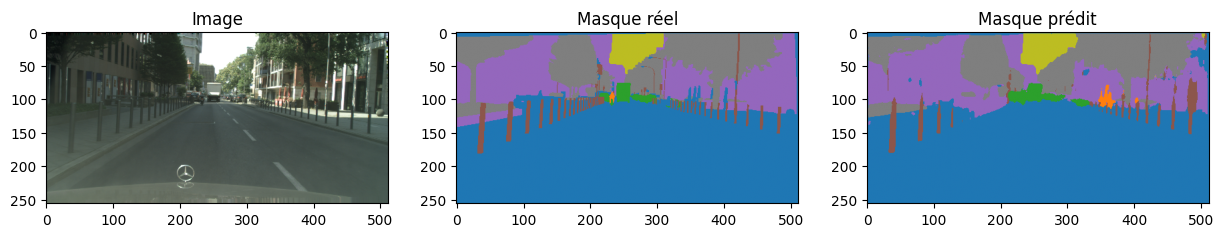

In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


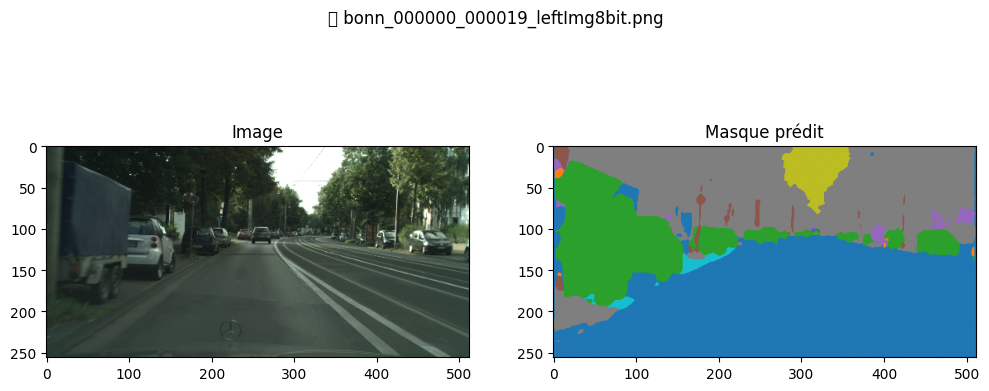

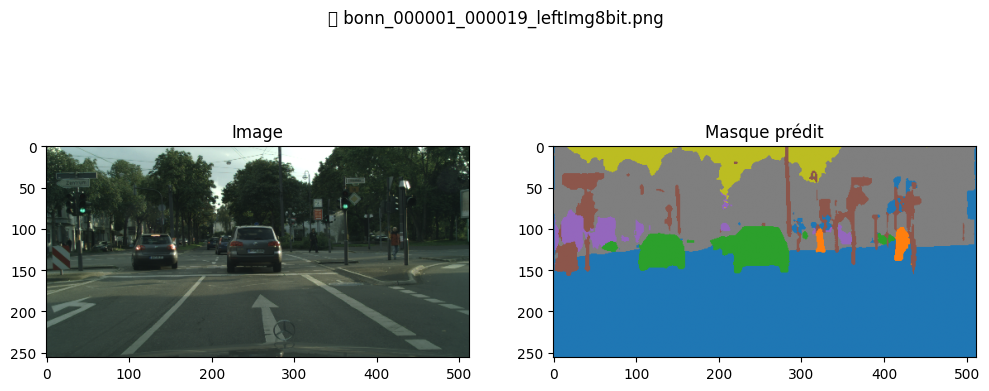

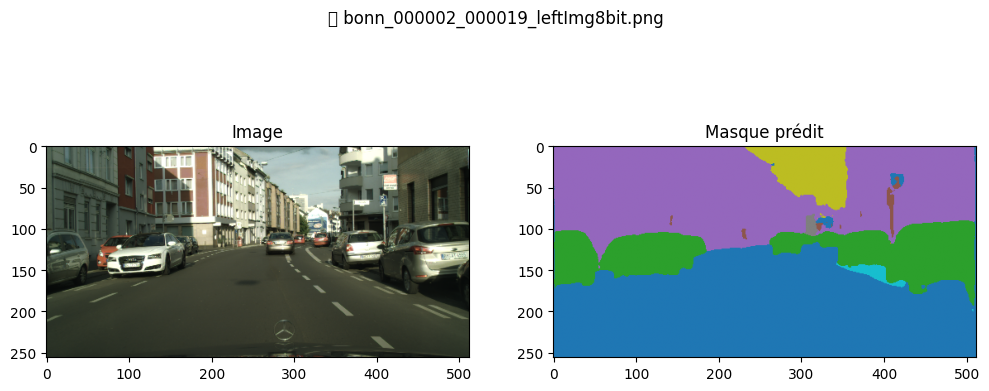

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

model4.eval()
with torch.no_grad():
    for img_tensor, path in test_loader:
        img_tensor = img_tensor.to(DEVICE)
        output = model4(img_tensor)
        pred_mask = output.argmax(1).squeeze(0).cpu().numpy()

        afficher_prediction(img_tensor, pred_mask, path[0], mean, std, NUM_CLASSES)



# DeeplabV3 et ResNet50

In [ ]:
import torchvision

import torchvision.models.segmentation as models
from torchvision.models.segmentation import deeplabv3_resnet50

from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

def get_deeplabv3_model(num_classes=8):
    model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
    model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)
    return model


In [ ]:
model5 = get_deeplabv3_model(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model5.parameters(), lr=LEARNING_RATE)



Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 206MB/s]


In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")

BEST_METRIC = -float("inf")
PATIENCE_COUNTER = 0
with mlflow.start_run(run_name="DeepLabV3_ResNet50"):

    mlflow.log_params({
        "model": "DeepLabV3_ResNet50",
        "optimizer": "Adam",
        "lr": LEARNING_RATE,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model5, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model5, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model5.state_dict(), "best_model_deeplabv3.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model_deeplabv3.pt")


Époch 1 | Train Loss: 0.6348 | Val Loss: 0.3986 | mIoU: 0.5746 | Pixel Acc: 0.9750
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 2 | Train Loss: 0.3357 | Val Loss: 0.3087 | mIoU: 0.6218 | Pixel Acc: 0.9769
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 3 | Train Loss: 0.2694 | Val Loss: 0.2706 | mIoU: 0.6359 | Pixel Acc: 0.9782
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 4 | Train Loss: 0.2373 | Val Loss: 0.2523 | mIoU: 0.6452 | Pixel Acc: 0.9788
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 5 | Train Loss: 0.2154 | Val Loss: 0.2554 | mIoU: 0.6408 | Pixel Acc: 0.9781
⚠️ Pas d'amélioration : 1/5
Époch 6 | Train Loss: 0.2029 | Val Loss: 0.2454 | mIoU: 0.6517 | Pixel Acc: 0.9790
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 7 | Train Loss: 0.1881 | Val Loss: 0.2328 | mIoU: 0.6531 | Pixel Acc: 0.9799
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 8 | Train Loss: 0.1771 | Val Loss: 0.2304 | mIoU: 0.6629 | Pi

In [ ]:
model5.load_state_dict(torch.load("best_model_deeplabv3.pt"))
model5.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model2(input_tensor)  # [1, num_classes, H, W]
    output = F.interpolate(output, size=IMG_SIZE, mode="bilinear", align_corners=False)
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


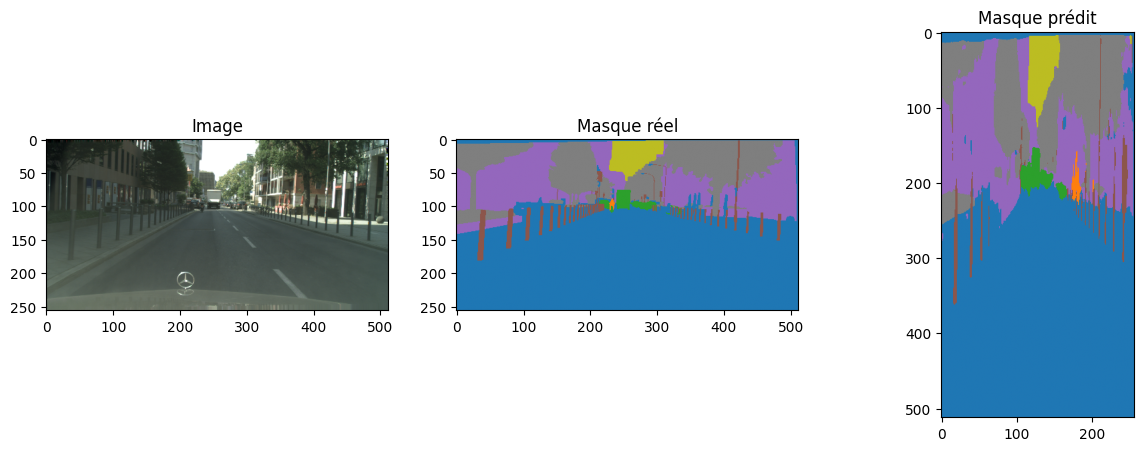

In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


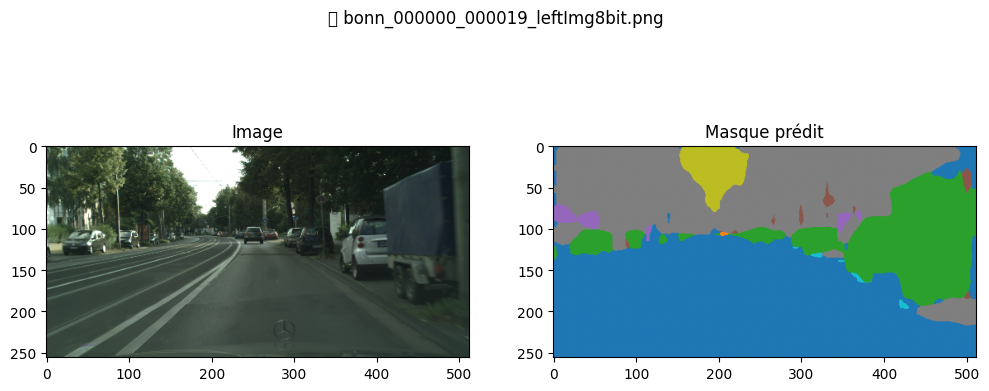

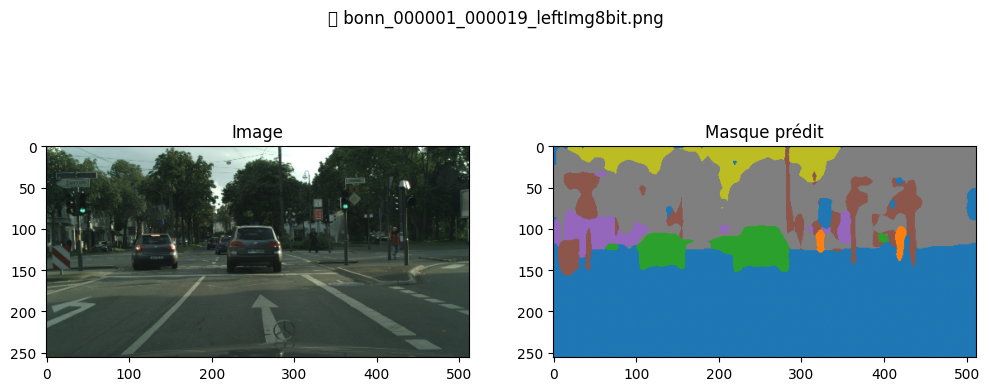

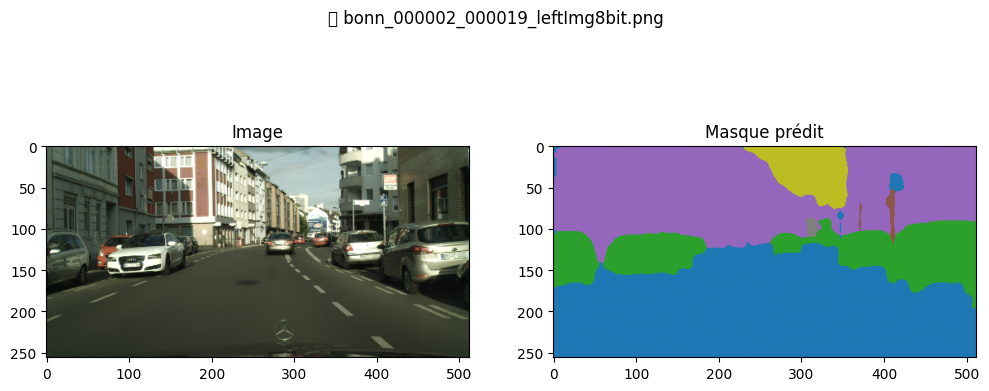

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

model5.eval()
with torch.no_grad():
    for img_tensor, path in test_loader:
        img_tensor = img_tensor.to(DEVICE)
        output = model5(img_tensor)
        pred_mask = output["out"].argmax(1).squeeze(0).cpu().numpy()


        afficher_prediction(img_tensor, pred_mask, path[0], mean, std, NUM_CLASSES)



Launch MLFlow on Google Collab

In [ ]:
!pip install mlflow pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 1.3 MB/s eta 0:00:00
